# Оптимизация инвестиционного портефля методом Марковица на языке Python

Здесь содержится общая идея оптимизации инвестиционного портфеля методом Марковица и то, как это реализовать на Python.  В дальнейшем будет описано как провести бэктестинг, который осуществляет ребалансировку оптимальным способом на основе модели Марковица.

In [1]:
import pandas as pd
import numpy as np
import scipy.optimize as sco
import matplotlib.pyplot as plt
import matplotlib.cm as cm

%matplotlib inline
# Для отрисовки сетки за графиком
plt.rc('axes', axisbelow=True)

Предположим,что у нас 4 акции, каждая с набором дохожности длиной 1000. Мы можем использовать `numpy.random.randn', чтобы смоделировать доходности из нормального распределения

In [2]:
stocks = ['A','B','C','D']

In [3]:
np.random.seed(123)

## Количество акций
n_assets = 4

## Количество наблюдений
n_obs = 1000

#return_vec = np.random.randn(n_assets, n_obs)
return_vec = np.random.randn(n_assets, n_obs)

Преобразуем сгенерированные акции в pandas DataFrame 

In [4]:
assets = np.array([return_vec[i].cumsum()+1000 for i in range(len(return_vec))]).T
table = pd.DataFrame(assets, columns = stocks)
table.head()

,A,B,C,D
0,998.914369,999.251173,998.225776,999.549401
1,999.911715,999.818767,997.024399,1000.158992
2,1000.194693,1000.536918,998.120656,1001.332736
3,998.688399,999.537537,998.981693,1002.204551
4,998.109798,1000.012435,997.461326,1004.109274


Так выглядят графики четырех сгенерированных акций

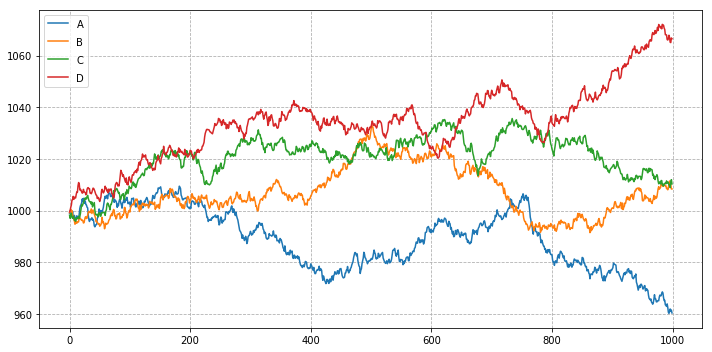

In [5]:
table.plot(figsize=(10, 5))
plt.grid(True, linestyle='--')
plt.legend(labelspacing=0.8)
plt.tight_layout();

## Граница эффективности

Моделирование совокупности инвестиционных портфелей графически представляется в форме «пули», верхняя линия которой является эффективной границей. Точки, лежащие на ней, представляют собой портфели с наименьшим уровнем риска для заданной доходности. Остальные точки, находящиеся правее соответсвуют большему риску при том же показатели ожидаемой доходности

Построение эффективной границы предполагает нахождение двух крайних точек (минимального риска и максимальной доходности с учетом показателя риска). Для этого используем Scipy's optimize function как альтернативу перебору всех возможных вариантов сформированных портфелей.
Scipy's optimize function сходна с функцией 'Поиск решения' в Excel, выполняет те же функции, при указании того, что нужно оптимизировать и какие при этом есть ограничения (constraints) и границы (bounds).

Ниже приведены функции для получения портфеля с наибольшим коэффициентом Шарпа. Данный показатель отражает во сколько раз уровень доходности выше уровня риска. Он указывает на стабильность прибыли, при этом отображая и ее количественную характеристику. 

Поскольку в Scipy's optimize function отсутствует «максимизация» в качестве целевой функции должно быть выбрано то, что следует минимизировать. Поэтому "neg_sharpe_ratio" вычисляет отрицательный коэффициент Шарпа. 

В функции "max_sharpe_ratio" сначала определяются аргументы (они не должны включать, те значения, которые будут изменяться в ходе оптимизации, в частности доли акций -"weights")

Поскольку доли акций в портфеле суммарно не должны превышать 1 (нельзя превысить бюджет более чем на 100 %) то:
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
Данное ограничение говорит о том, что сумма x должна быть равна 1. 

Для лучшего понимания можно рассматривать данное условие как перенос 1 в левую сторону равенства:
'np.sum(x) == 1' has become 'np.sum(x)-1'


Границы задают другое ограничения для долей акции – они должны лежать в интервале от 0 до 1. Ведь нельзя задать отрицательное распределение ровно, как и превысить 100% показатель.


In [6]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) * num_periods_annually
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(num_periods_annually)
    return std, returns

In [7]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

In [8]:
def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

Также можно определить оптимизирующую функцию для расчета минимального показателя риска. На этот раз минимизируем целевую функцию – риск (min_variance), используя разные показатели долей акций. "Constraints" и "bounds" такие же, как и выше.

In [9]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

In [10]:
def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                          method='SLSQP', bounds=bounds, constraints=constraints)

    return result

Как уже упоминалось выше эффективная граница — это линия, которая отражает, где находятся эффективные портфели для заданного уровня риска. Ниже приведены функции для ее вычисления. Первая - "efficient_return" вычисляет самый эффективный портфель для заданного риска, а вторая - "efficient_frontier" принимает диапазон целевых доходностей и вычисляет эффективный портфель для каждой из них.

In [11]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                          method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [12]:
def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

Построим портфель с максимальным коэффициентом Шарпа и минимальным риском, а также отразим все случайно сгенерированные портфели. При этом мы не выбираем оптимальные портфели из случайно сгенерированных, а вычисляем их, используя Scipy's 'minimize' function. Приведенная ниже функция также строит границу эффективности.

In [13]:
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(len(stocks))
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

---

In [39]:
num_portfolios = 25000 # Кол-во расчитываемых портфелей (итераций)
risk_free_rate = 0.00 # Безрисковая процентная ставка
num_periods_annually = 252 # Количество операционных дней в году

In [40]:
returns = table.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()

Оптимизируем. Ищем портфель с максимальным коэффициентом шарпа (max_sharpe) и минимальным риском (min_vol)

In [41]:
max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
min_vol = min_variance(mean_returns, cov_matrix)

In [44]:
sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
max_sharpe_allocation = max_sharpe_allocation.T

In [45]:
sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
min_vol_allocation = min_vol_allocation.T

Находим (оптимизируем) эффективную границу портфелей

In [46]:
target = np.linspace(rp_min, 0.017, 20)
efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)

Преобразуем оптимизированные параметры для нормального отображения при использовании print

Генерируем (метод Монте Карло) num_portfolios случайных портфелей для отрисовки их на графике

In [47]:
results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.013
Annualised Volatility: 0.011
Sharpe Ratio: 1.121


              A     B      C      D
allocation  0.0  13.9  13.58  72.52
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.003
Annualised Volatility: 0.007
Sharpe Ratio: 0.413


               A     B     C     D
allocation  25.0  25.0  25.0  25.0


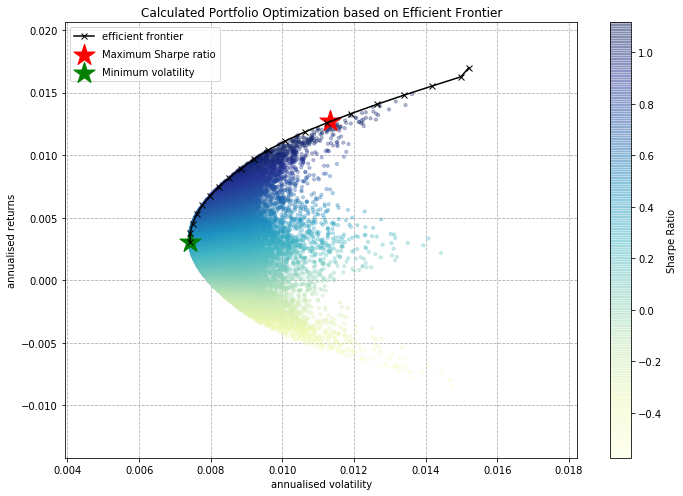

In [51]:
print("-"*80)
print("Распределение долей акций в портфеле с максимальным коэффициентом Шарпа:n")
print("Годовая доходность:", round(rp,3))
print("Годовой риск:", round(sdp,3))
print("Коэффициент Шарпа", round((rp - risk_free_rate)/sdp, 3))
print("\n")
print(max_sharpe_allocation)
print("-"*80)
print("Распределение долей акций в портфеле с наименьшим показателем риска:\n")
print("Годовая доходность:", round(rp_min,3))
print("Годовой риск:", round(sdp_min,3))
print("Коэффициент Шарпа:", round((rp_min - risk_free_rate)/sdp_min, 3))
print("\n")
print(min_vol_allocation)

plt.figure(figsize=(10, 7))
plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
plt.colorbar(label='Коэффициент Шарпа')
plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Максимальный коэф-т Шарпа')
plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Минимальный риск')

plt.plot([p['fun'] for p in efficient_portfolios], target, 'k-x', label='граница эффективности')
plt.title('Оптимизация портфеля на основе построения эффективной границы')
plt.xlabel('Риск(стандартное отклонение)')
plt.ylabel('Доходность')
plt.grid(True, linestyle='--')
plt.legend(labelspacing=0.8)

plt.tight_layout();

*Граница эффективности для портфелей с различным распределением долей 4 акций. Красная звезда: Максимальный коэффициент Шарпа; Зеленая звезда: Минимальный риск; Черные метки и линия: Граница эффективности.*

Вместо построения графика каждого случайно сгенерированного портфеля мы можем построить график каждой отдельной акции на графике с соответствующими значениями годовой доходности и годового риска. Что наглядно демонстрирует то, как диверсификация снижает риск за счет оптимизации распределения.

In [53]:
max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
max_sharpe_allocation = max_sharpe_allocation.T

min_vol = min_variance(mean_returns, cov_matrix)
sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
min_vol_allocation = min_vol_allocation.T

an_vol = np.std(returns) * np.sqrt(num_periods_annually)
an_rt = mean_returns * num_periods_annually

In [54]:
target = np.linspace(rp_min, 0.017, 20)
efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.01
Annualised Volatility: 0.01
Sharpe Ratio: 1.121


              A     B      C      D
allocation  0.0  13.9  13.58  72.52
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.0
Annualised Volatility: 0.01
Sharpe Ratio: 0.413


               A     B     C     D
allocation  25.0  25.0  25.0  25.0
--------------------------------------------------------------------------------
Individual Stock Returns and Volatility

A : annuaised return -0.01 , annualised volatility: 0.02
B : annuaised return 0.0 , annualised volatility: 0.02
C : annuaised return 0.0 , annualised volatility: 0.02
D : annuaised return 0.02 , annualised volatility: 0.02
--------------------------------------------------------------------------------


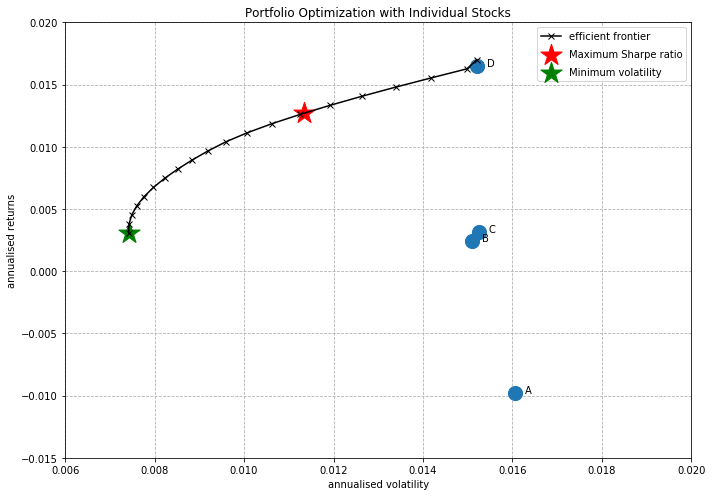

In [55]:
print("-"*80)
print("Распределение долей акций в портфеле с максимальным коэффициентом Шарпа\n")
print("Годовая доходность:", round(rp,2))
print("Годовой риск:", round(sdp,2))
print("Коэффициент Шарпа:", round((rp - risk_free_rate)/sdp, 3))
print("\n")
print(max_sharpe_allocation)
print("-"*80)
print("Распределение долей акций в портфеле с наименьшим показателем риска:\n")
print("Годовая доходность:", round(rp_min,2))
print("Годовой риск:", round(sdp_min,2))
print("Коэффициент Шарпа:", round((rp_min - risk_free_rate)/sdp_min, 3))
print("\n")
print(min_vol_allocation)
print("-"*80)

print("Показатели доходности и риска каждой отдельной акции\n")
for i, txt in enumerate(table.columns):
    print(txt,":","годовая доходность:",round(an_rt[i],2),", годовой риск:",round(an_vol[i],2))
print("-"*80)

plt.subplots(figsize=(10, 7))
plt.scatter(an_vol,an_rt,marker='o',s=200)


for i, txt in enumerate(table.columns):
    plt.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')

plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Максимальный коэф-т Шарпа')
plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Минимальный риск')

plt.plot([p['fun'] for p in efficient_portfolios], target, 'k-x', label='граница эффективности')
plt.title('Оптимизация портфеля и показатели отдельный акций')
plt.xlabel('Риск(стандартное отклонение)')
plt.ylabel('Доходность')
plt.legend(labelspacing=0.8)
plt.grid(True, linestyle='--')

plt.xlim(0.006, 0.02)
plt.ylim(-0.015, 0.02)

plt.tight_layout();

Как видно из графика акция с наименьшим уровнем риска - B, но оптимизируя портфель может быть достигнут меньший риск, с тем же показателем доходности, что и B 

In [56]:
ind = np.arange(n_assets)
width = 0.35

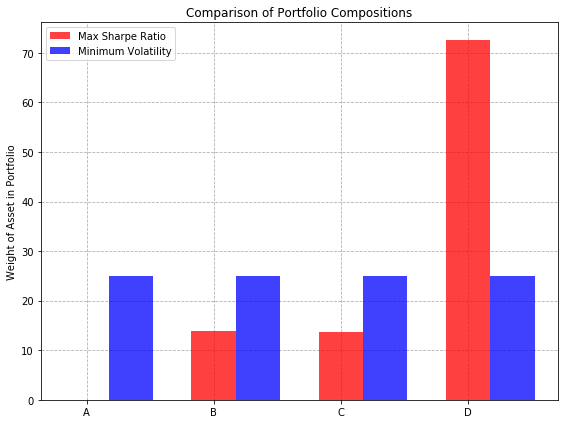

In [57]:
plt.figure(figsize=(8,6))
plt.bar(ind, max_sharpe['x'], width, color='r', alpha=0.75)
plt.bar(ind + width, min_vol['x'], width, color='b', alpha=0.75)

plt.xticks(ind, stocks)
plt.ylabel('Распределение акций в портфеле')
plt.title('Сравнение сотавов портфелей')
plt.legend(('Максимальный коэф-т Шарпа', 'Минимальный Риск'))
plt.grid(b=True, linestyle='--')

plt.tight_layout()

*Доли акций в портфеле с различными целями(максимизация доходности/минимизация риска )*